# Hough Transform
The Hough transform is a feature extraction technique used in image analysis, computer vision, and digital image processing. The purpose of the technique is to find imperfect instances of objects within a certain class of shapes by a voting procedure. This voting procedure is carried out in a parameter space, from which object candidates are obtained as local maxima in a so-called accumulator space that is explicitly constructed by the algorithm for computing the Hough transform.

In [1]:
import numpy as np
from matplotlib import pyplot as plt 
from skimage.filters.rank import gradient
from skimage.morphology import disk
from skimage.transform import hough_line, hough_line_peaks
import cv2
%matplotlib inline

## Open Image
UFPR.jpg <br>
lines.png <br>
wave.jpg 

(708, 1280)


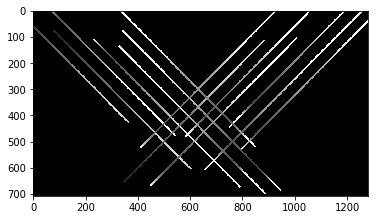

In [2]:
im_gray = cv2.imread('imgs/lines.png',cv2.IMREAD_GRAYSCALE)
print(im_gray.shape)
plt.imshow(im_gray,cmap='gray')

## Gradient Image

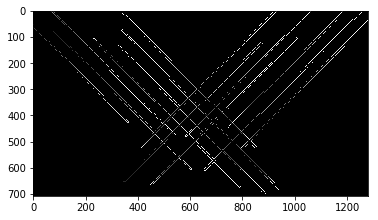

In [3]:
im_grad = gradient(im_gray, disk(1))
plt.imshow(im_grad,cmap='gray')

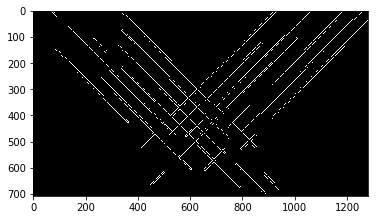

In [4]:
# Otsu's thresholding 
ret3,im_bin = cv2.threshold(im_grad,0,255,cv2.THRESH_OTSU)
plt.imshow(im_bin,cmap='gray')

## Hough Transform
$r = xcos(\theta)+ysin(\theta)$ <br>
$r \in \left[-\sqrt{M^2+N^2},\sqrt{M^2+N^2}\right]$<br>
$\theta \in \left[ -\dfrac{\pi}{2},\dfrac{\pi}{2}\right]$ <br>

In [5]:
y_max, x_max = im_bin.shape

r_max = np.sqrt(y_max**2+x_max**2)
r_min = -r_max
r_steps = np.ceil(r_max-r_min).astype('int')
r_step = (r_max-r_min)/(r_steps-1)
r_list = np.arange(r_min,r_max+r_step,r_step)
if r_list.shape[0]!=r_steps:
    r_list = r_list[:-1]

o_steps = 2000
o_max = -np.pi/2
o_min = -o_max
o_step = (o_max-o_min)/(o_steps-1)
o_list = np.arange(o_min,o_max+o_step,o_step)
if o_list.shape[0]!=o_steps:
    o_list = o_list[:-1]

r_steps,o_list.shape

(2926, (2000,))

In [6]:
%%time
im_hough = np.zeros((r_steps,o_steps))
for y in range(im_bin.shape[0]):
    for x in range(im_bin.shape[1]):
        if im_bin[y,x]:
            r_o_list = x*np.cos(o_list)+y*np.sin(o_list)
            r = np.round((r_o_list-r_min)/r_step).astype('int')
            im_hough[r,range(o_steps)]+=1
            

CPU times: user 7.41 s, sys: 21.4 ms, total: 7.43 s
Wall time: 7.43 s


(2926, 2000)


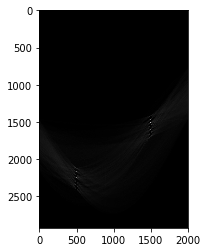

In [7]:
print(im_hough.shape)
plt.imshow(im_hough,cmap='gray')

## Plot lines

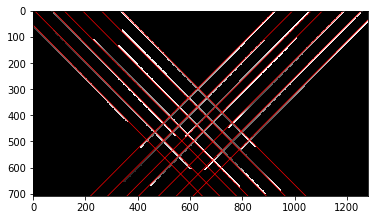

In [8]:
_, angles, dists = hough_line_peaks(im_hough, o_list, r_list)
pts1 = np.around(dists/np.sin(angles))                        #x=0     => [0,r/sin(o)]
pts2 = np.around((dists-x_max*np.cos(angles))/np.sin(angles)) #x=x_max => [x_max,(r-x_max.cos(o))/sin(o)]

#plot
plt.imshow(im_gray, cmap='gray')
for pt1,pt2 in zip(pts1,pts2):
    #plt.plot(x,y)
    plt.plot((0, x_max), (pt1, pt2), 'r',linewidth=0.7)
    
    
# [xmin, xmax, ymin, ymax]
plt.axis((0,x_max,y_max,0))
plt.show()

## Skimage

(2926, 2000)
CPU times: user 486 ms, sys: 97.3 ms, total: 584 ms
Wall time: 472 ms


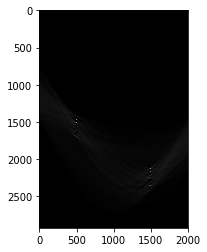

In [9]:
%%time
h, theta, d = hough_line(im_bin,np.arange(-np.pi/2,np.pi/2,np.pi/2000))
print(h.shape)
plt.imshow(h,cmap='gray')

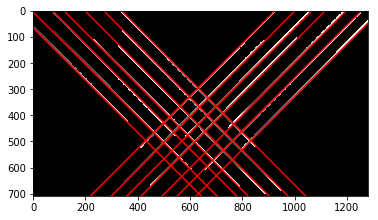

In [10]:
#print lines
plt.imshow(im_gray, cmap='gray')
row1, col1 = im_gray.shape
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - col1 * np.cos(angle)) / np.sin(angle)
    plt.plot((0, col1), (y0, y1), '-r')
plt.axis((0, col1, row1, 0))
plt.show()